### 输出原始序列和预测序列

In [1]:
import util
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from utils import earlystopping

print('start train...')
# torch.cuda.set_device(1)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model_save_path = "./data/save_models/simpleLSTM/LSTM.pth"

input_size = 24
predict_size = 3
train_epoch = 150
class lstm(nn.Module):
    def __init__(self, input_size=24, output_size=9, hidden_size=64,  num_layer=2):
        super(lstm, self).__init__()
        self.layer1 = nn.LSTM(input_size, hidden_size, num_layer)
        self.layer2 = nn.Linear(hidden_size, output_size)
        # self.layer3 = nn.Linear(32, output_size)

    def forward(self, x):
        x, _ = self.layer1(x)
        s, b, h = x.size()
        x = x.view(s * b, h)  # view函数调整矩阵的形状，类似于reshape
        # x = F.relu(x)
        x = self.layer2(x)
        # x = F.relu(x)
        # x = self.layer3(x)
        x = x.view(s, b, -1)
        return x

# 参数设定
root_dir = 'data/water/shangban'
factor_index = 0
site_index = 0
input_length = 24
output_length = 3



site_code = "abcdefghijklmn"
dataloader = util.load_dataset(root_dir + '/singlesingle/{}{}'.format(factor_index,site_code[site_index]),
                               64, 64, 64, False)

model = lstm(input_length, output_length).to(device)
model = model.double()

start train...
Using cpu device


In [33]:
model.eval()
model.load_state_dict(torch.load(model_save_path,map_location=torch.device('cpu')))
scaler = dataloader['scaler']
# loss_list = []
with torch.no_grad():
    X,y = dataloader['test_loader'].get_origin()
    X = scaler.transform(X)

    X = np.expand_dims(X, axis=1)
    y = np.expand_dims(y, axis=1)

    X = torch.tensor(X).to(device)
    y = torch.tensor(y).to(device)

    pred = model(X)
    pred_real = scaler.inverse_transform(pred)

    print(X.shape)
    print(y.shape)
    print(pred_real.shape)

torch.Size([361, 1, 24])
torch.Size([361, 1, 3])
torch.Size([361, 1, 3])


In [34]:
# num_x = X.to('cpu').numpy()
origin_x = scaler.inverse_transform(X).to('cpu').numpy()
num_y = y.to('cpu').numpy()
num_pred = pred_real.to('cpu').numpy()

i_size = origin_x.shape[2]
o_size = num_y.shape[2]
seq_size = origin_x.shape[0] + i_size - 1

dimen_length = origin_x.shape[1]
seqs = []
for dimen in range(dimen_length):
    seq_x = origin_x[0,dimen,:]
    seq_x_mid = origin_x[1:,dimen,-1]
    seq_x = np.append(seq_x,seq_x_mid)
    seq_x = np.append(seq_x,num_y[-1,dimen,:])
    pad = np.zeros([i_size ,1])
    pad_right = np.zeros([o_size - 1,1])
    seq_y1 =np.append(pad,num_pred[:,dimen,0])
    seq_y1 =np.append(seq_y1,pad_right)
    # seq_y1 = np.hstack()
    seq_y2 =np.append(pad,num_pred[:,dimen,1])
    seq_y2 =np.append(seq_y2,pad_right)
    seq_y3 =np.append(pad,num_pred[:,dimen,2])
    seq_y3 =np.append(seq_y3,pad_right)

    print(seq_x.shape)
    print(seq_y1.shape)
    print(seq_y2.shape)
    print(seq_y3.shape)

    seq = [seq_x.tolist(),seq_y1.tolist(),seq_y2.tolist(),seq_y3.tolist()]
    seqs.append(seq)



csv_str = ""
for seq in seqs:
    seqx = [str(i) for i in range(len(seq[0]))]
    line_str = ",".join(seqx)
    csv_str += line_str
    csv_str += '\n'
    for one in seq:
        # float 转str
        for i in range(len(one)):
            one[i] = "{:.3f}".format(one[i])
        line_str = ",".join(one)
        csv_str += line_str
        csv_str += '\n'
# seqx = range(len(seqs[0][0]))
# print(seqx)
with open('temp.csv','w') as f:
    f.write(csv_str)


print(csv_str)

(387,)
(387,)
(387,)
(387,)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,27

range(0, 387)
['6.080', '5.940', '6.010', '6.130', '6.180', '6.210', '6.190', '6.070', '6.090', '6.180', '6.230', '6.280', '6.250', '6.220', '6.200', '6.210', '6.250', '6.230', '6.230', '6.020', '6.330', '6.280', '6.310', '6.210', '6.120', '5.890', '6.210', '6.240', '6.070', '6.070', '6.120', '5.940', '6.200', '6.100', '6.220', '6.170', '6.170', '5.830', '5.990', '5.720', '6.060', '6.100', '6.110', '5.880', '5.970', '5.630', '5.257', '4.946', '4.695', '4.505', '4.376', '4.307', '4.300', '4.353', '4.467', '4.642', '4.878', '5.175', '5.532', '5.951', '6.430', '6.970', '7.571', '8.232', '8.955', '9.719', '10.415', '11.022', '11.541', '11.973', '12.316', '12.571', '12.738', '12.818', '12.809', '12.712', '12.527', '12.254', '11.893', '11.445', '10.908', '10.283', '9.570', '8.769', '7.880', '7.030', '6.830', '6.570', '6.490', '6.540', '6.430', '6.440', '6.310', '6.220', '5.890', '5.910', '5.960', '5.910', '5.940', '5.900', '5.890', '6.010', '6.090', '5.940', '5.960', '5.910', '5.940', '5.950

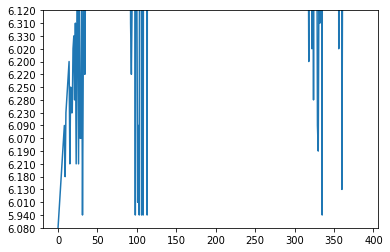

In [21]:
# import matplotlib.pyplot as plt
# for seq in seqs:
#     # for one in seq:
#     x = range(len(seq[0]))
#     y = seq[0]
#     plt.plot(x,y)
#     plt.ylim((0,17))
# print(x)
# print(y)
# plt.show()